In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
import joblib

# Load the dataset
df = pd.read_csv("health_insurance_synthetic_data.csv")

# Explore the data
print(df.head())
print("\nClass distribution:")
print(df['fraud'].value_counts(normalize=True))

# Prepare features and target
X = df.drop('fraud', axis=1)
y = df['fraud']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Create preprocessing and modeling pipeline
model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
)

# Train the model
model.fit(X_train_res, y_train_res)

# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("\nEvaluation Metrics:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))

# Feature importance
feature_importances = model.named_steps['randomforestclassifier'].feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
print("\nTop 10 Important Features:")
print(importance_df.sort_values(by='Importance', ascending=False).head(10))

# Save the model for future use
joblib.dump(model, 'fraud_detection_model.pkl')
print("\nModel saved as fraud_detection_model.pkl")

# Example prediction
sample_data = X_test.iloc[0:1].copy()
print("\nSample prediction:")
print("Input features:")
print(sample_data)
print("Predicted class:", model.predict(sample_data)[0])
print("Predicted probability:", model.predict_proba(sample_data)[0][1])

   gender  primary_diagnosis  procedure_type  claim_day  patient_age  \
0       1                  0               2          1           75   
1       1                  3               1          0           37   
2       1                  2               2          4           34   
3       1                  3               2          2           61   
4       0                  3               1          6           18   

   claim_amount  num_procedures  hospital_stay_days  cost_feature_1  \
0   4103.301432               1                   6        0.703757   
1   9620.837954               3                  12        0.392903   
2  13672.708563               4                  10        0.234176   
3   8920.729233               3                   1        0.482315   
4  16066.677786               4                   7        0.305189   

   util_feature_2  usage_score  billing_variance  frequency_of_visits  \
0        0.937613     0.477661          0.341252             0.2332

In [2]:
import pandas as pd
import joblib

# Load the trained model
model = joblib.load('fraud_detection_model.pkl')

# Define a sample claim data (adjust these values as needed)
# Note: Categorical features must be encoded like the original data
new_claim = {
    'gender': 1,                   # 0=Female, 1=Male (encoded)
    'primary_diagnosis': 2,        # Encoded: 0=Cancer, 1=Diabetes, 2=Heart Disease, 3=Other
    'procedure_type': 3,           # Encoded: 0=Consultation, 1=Emergency, 2=Surgery, 3=Test
    'claim_day': 4,                # Encoded: 0=Friday, 1=Monday, 2=Saturday, 3=Sunday, 4=Thursday, 5=Tuesday, 6=Wednesday
    'patient_age': 45,
    'claim_amount': 12500.50,
    'num_procedures': 3,
    'hospital_stay_days': 5,
    'cost_feature_1': 0.65,
    'util_feature_2': 0.42,
    'usage_score': 0.78,
    'billing_variance': 0.23,
    'frequency_of_visits': 0.55,
    'anomaly_score': 0.87,
    'hospital_id': 5,
    'provider_id': 7,
    'claim_month': 6
}

# Convert to DataFrame
new_data = pd.DataFrame([new_claim])

# Make prediction
fraud_prediction = model.predict(new_data)
fraud_probability = model.predict_proba(new_data)[0][1]

# Interpret results
print("Sample Claim Features:")
print(new_data)
print("\nFraud Prediction:", "Fraud" if fraud_prediction[0] == 1 else "Not Fraud")
print("Fraud Probability:", f"{fraud_probability:.2%}")

Sample Claim Features:
   gender  primary_diagnosis  procedure_type  claim_day  patient_age  \
0       1                  2               3          4           45   

   claim_amount  num_procedures  hospital_stay_days  cost_feature_1  \
0       12500.5               3                   5            0.65   

   util_feature_2  usage_score  billing_variance  frequency_of_visits  \
0            0.42         0.78              0.23                 0.55   

   anomaly_score  hospital_id  provider_id  claim_month  
0           0.87            5            7            6  

Fraud Prediction: Fraud
Fraud Probability: 58.00%


In [3]:
import pandas as pd
import joblib

def load_model_and_predict(new_data):
    # Load the trained model
    model = joblib.load('fraud_detection_model.pkl')
    
    # Make predictions
    predictions = model.predict(new_data)
    probabilities = model.predict_proba(new_data)
    
    # Create results DataFrame
    results = new_data.copy()
    results['prediction'] = predictions
    results['non_fraud_probability'] = probabilities[:, 0]
    results['fraud_probability'] = probabilities[:, 1]
    
    # Map prediction codes to labels
    results['prediction_label'] = results['prediction'].map({0: 'Non-Fraud', 1: 'Fraud'})
    
    return results

# Example 1: Single non-fraud case
non_fraud_example = {
    'gender': 0,
    'primary_diagnosis': 1,
    'procedure_type': 2,
    'claim_day': 5,
    'patient_age': 32,
    'claim_amount': 4500.00,
    'num_procedures': 2,
    'hospital_stay_days': 2,
    'cost_feature_1': 0.12,
    'util_feature_2': 0.08,
    'usage_score': 0.15,
    'billing_variance': 0.03,
    'frequency_of_visits': 0.10,
    'anomaly_score': 0.05,
    'hospital_id': 3,
    'provider_id': 2,
    'claim_month': 4
}

# Example 2: Single fraud case
fraud_example = {
    'gender': 1,
    'primary_diagnosis': 3,
    'procedure_type': 1,
    'claim_day': 6,
    'patient_age': 58,
    'claim_amount': 18500.00,
    'num_procedures': 5,
    'hospital_stay_days': 12,
    'cost_feature_1': 0.92,
    'util_feature_2': 0.87,
    'usage_score': 0.95,
    'billing_variance': 0.78,
    'frequency_of_visits': 0.92,
    'anomaly_score': 0.98,
    'hospital_id': 8,
    'provider_id': 9,
    'claim_month': 11
}

# Create DataFrame with both examples
examples = pd.DataFrame([non_fraud_example, fraud_example])

# Get predictions
predictions_df = load_model_and_predict(examples)

# Display detailed results
print("Prediction Results:")
print(predictions_df[['prediction_label', 'non_fraud_probability', 'fraud_probability']])

# Save results to CSV
predictions_df.to_csv('prediction_results.csv', index=False)
print("\nResults saved to prediction_results.csv")

Prediction Results:
  prediction_label  non_fraud_probability  fraud_probability
0        Non-Fraud                   0.85               0.15
1        Non-Fraud                   0.67               0.33

Results saved to prediction_results.csv


In [6]:
import pandas as pd
import joblib
import numpy as np

def predict_with_threshold(model, data, threshold=0.6):
    """Adjust prediction threshold for better sensitivity"""
    probs = model.predict_proba(data)[:, 1]
    return (probs >= threshold).astype(int)

# Load model
model = joblib.load('fraud_detection_model.pkl')

# Modified examples with clearer patterns
clear_non_fraud = {
    'gender': 0,
    'primary_diagnosis': 1,  # Diabetes
    'procedure_type': 0,     # Consultation
    'claim_day': 1,          # Monday
    'patient_age': 35,
    'claim_amount': 2500.00,
    'num_procedures': 1,
    'hospital_stay_days': 1,
    'cost_feature_1': 0.15,
    'util_feature_2': 0.10,
    'usage_score': 0.18,
    'billing_variance': 0.05,
    'frequency_of_visits': 0.12,
    'anomaly_score': 0.10,
    'hospital_id': 2,
    'provider_id': 2,
    'claim_month': 3
}

clear_fraud = {
    'gender': 1,
    'primary_diagnosis': 0,  # Cancer
    'procedure_type': 3,     # Test
    'claim_day': 6,          # Wednesday
    'patient_age': 55,
    'claim_amount': 18250.00,
    'num_procedures': 5,
    'hospital_stay_days': 13,
    'cost_feature_1': 0.95,
    'util_feature_2': 0.91,
    'usage_score': 0.97,
    'billing_variance': 0.88,
    'frequency_of_visits': 0.94,
    'anomaly_score': 0.99,
    'hospital_id': 9,
    'provider_id': 9,
    'claim_month': 12
}

# Create DataFrame
examples = pd.DataFrame([clear_non_fraud, clear_fraud])

# Get probabilities
fraud_probs = model.predict_proba(examples)[:, 1]

# Adjustable threshold (default 0.5)
threshold = 0.4  # Lower threshold to catch more fraud

# Get predictions
predictions = np.where(fraud_probs >= threshold, 1, 0)

# Create result report
results = examples.copy()
results['Fraud_Probability'] = fraud_probs
results['Prediction'] = predictions
results['Prediction_Label'] = np.where(predictions == 1, 'Fraud', 'Non-Fraud')

print("Enhanced Prediction Results:")
print(results[['Prediction_Label', 'Fraud_Probability']])

Enhanced Prediction Results:
  Prediction_Label  Fraud_Probability
0        Non-Fraud               0.22
1        Non-Fraud               0.21


In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Configuration
n_samples = 5000
fraud_ratio = 0.18  # Real-world fraud percentage

# Base features
data = {
    'patient_age': np.random.randint(18, 85, n_samples),
    'gender': np.random.choice(['Male', 'Female'], n_samples),
    'provider_id': np.random.randint(1, 50, n_samples),
    'hospital_id': np.random.choice(list(range(1, 20)) + [99]*100, n_samples),  # Hospital 99 is suspicious
    'claim_month': np.random.choice(['Jan', 'Mar', 'Jun', 'Dec'], n_samples),  # Months with higher fraud
    'procedure_type': None,
    'diagnosis_code': None,
    'claim_amount': None,
    'num_procedures': None,
    'days_admitted': None,
    'previous_claims': np.random.poisson(1.5, n_samples),
    'billing_discrepancy': np.zeros(n_samples),
    'anomaly_score': np.zeros(n_samples),
    'fraud': np.zeros(n_samples)
}

# Create DataFrame
df = pd.DataFrame(data)

# Generate fraud indicators
n_fraud = int(n_samples * fraud_ratio)
fraud_indices = np.random.choice(n_samples, n_fraud, replace=False)

# Non-fraud patterns
df['procedure_type'] = np.random.choice(['Routine Check', 'Blood Test', 'X-Ray', 'Vaccination'], n_samples)
df['diagnosis_code'] = np.random.choice(['J45', 'I10', 'E11', 'M54'], n_samples)
df['claim_amount'] = np.random.lognormal(6.5, 0.3, n_samples)
df['num_procedures'] = np.random.poisson(2, n_samples)
df['days_admitted'] = np.random.choice([0, 1, 2], n_samples, p=[0.7, 0.2, 0.1])

# Fraud patterns
df.loc[fraud_indices, 'procedure_type'] = np.random.choice(['MRI Scan', 'Surgery', 'Specialist Consult'], n_fraud)
df.loc[fraud_indices, 'diagnosis_code'] = np.random.choice(['C34', 'I21', 'E66'], n_fraud)
df.loc[fraud_indices, 'claim_amount'] = np.random.lognormal(8.5, 0.5, n_fraud)  # Higher claims
df.loc[fraud_indices, 'num_procedures'] = np.random.poisson(5, n_fraud)  # More procedures
df.loc[fraud_indices, 'days_admitted'] = np.random.choice([3, 4, 5], n_fraud, p=[0.5, 0.3, 0.2])
df.loc[fraud_indices, 'previous_claims'] = np.random.poisson(4.5, n_fraud)
df.loc[fraud_indices, 'billing_discrepancy'] = np.abs(np.random.normal(0.7, 0.2, n_fraud))
df.loc[fraud_indices, 'anomaly_score'] = np.random.beta(2, 5, n_fraud) + 0.5
df.loc[fraud_indices, 'fraud'] = 1

# Normalize anomaly scores
df['anomaly_score'] = np.clip(df['anomaly_score'], 0, 1)

# Add hospital patterns
df.loc[df['hospital_id'] == 99, 'fraud'] = 1
df.loc[df['hospital_id'] == 99, 'anomaly_score'] = np.random.uniform(0.7, 1.0, sum(df['hospital_id'] == 99))

# Add temporal patterns
df['claim_month'] = df['claim_month'].astype('category')
month_fraud_prob = {'Jan': 0.25, 'Mar': 0.22, 'Jun': 0.18, 'Dec': 0.35}
df['month_fraud_risk'] = df['claim_month'].map(month_fraud_prob)

# Encode categorical features
le = LabelEncoder()
cat_cols = ['gender', 'procedure_type', 'diagnosis_code', 'claim_month']
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Create final risk score
df['risk_score'] = (0.3 * df['anomaly_score'] +
                   0.25 * df['billing_discrepancy'] +
                   0.2 * (df['num_procedures']/10) +
                   0.15 * (df['claim_amount']/100000) +
                   0.1 * df['month_fraud_risk'])

# Save dataset
df.to_csv("enhanced_medical_fraud_data.csv", index=False)
print("Enhanced medical fraud dataset generated with realistic patterns!")

TypeError: unsupported operand type(s) for *: 'float' and 'Categorical'

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Configuration
n_samples = 5000
fraud_ratio = 0.18

# Base features
data = {
    'patient_age': np.random.randint(18, 85, n_samples),
    'gender': np.random.choice(['Male', 'Female'], n_samples),
    'provider_id': np.random.randint(1, 50, n_samples),
    'hospital_id': np.random.choice(list(range(1, 20)) + [99]*100, n_samples),
    'claim_month': np.random.choice(['Jan', 'Mar', 'Jun', 'Dec'], n_samples),
    'procedure_type': None,
    'diagnosis_code': None,
    'claim_amount': None,
    'num_procedures': None,
    'days_admitted': None,
    'previous_claims': np.random.poisson(1.5, n_samples),
    'billing_discrepancy': np.zeros(n_samples),
    'anomaly_score': np.zeros(n_samples),
    'fraud': np.zeros(n_samples)
}

df = pd.DataFrame(data)

n_fraud = int(n_samples * fraud_ratio)
fraud_indices = np.random.choice(n_samples, n_fraud, replace=False)

# Non-fraud patterns
df['procedure_type'] = np.random.choice(['Routine Check', 'Blood Test', 'X-Ray', 'Vaccination'], n_samples)
df['diagnosis_code'] = np.random.choice(['J45', 'I10', 'E11', 'M54'], n_samples)
df['claim_amount'] = np.random.lognormal(6.5, 0.3, n_samples)
df['num_procedures'] = np.random.poisson(2, n_samples)
df['days_admitted'] = np.random.choice([0, 1, 2], n_samples, p=[0.7, 0.2, 0.1])

# Fraud patterns
df.loc[fraud_indices, 'procedure_type'] = np.random.choice(['MRI Scan', 'Surgery', 'Specialist Consult'], n_fraud)
df.loc[fraud_indices, 'diagnosis_code'] = np.random.choice(['C34', 'I21', 'E66'], n_fraud)
df.loc[fraud_indices, 'claim_amount'] = np.random.lognormal(8.5, 0.5, n_fraud)
df.loc[fraud_indices, 'num_procedures'] = np.random.poisson(5, n_fraud)
df.loc[fraud_indices, 'days_admitted'] = np.random.choice([3, 4, 5], n_fraud, p=[0.5, 0.3, 0.2])
df.loc[fraud_indices, 'previous_claims'] = np.random.poisson(4.5, n_fraud)
df.loc[fraud_indices, 'billing_discrepancy'] = np.abs(np.random.normal(0.7, 0.2, n_fraud))
df.loc[fraud_indices, 'anomaly_score'] = np.random.beta(2, 5, n_fraud) + 0.5
df.loc[fraud_indices, 'fraud'] = 1

df['anomaly_score'] = np.clip(df['anomaly_score'], 0, 1)
df.loc[df['hospital_id'] == 99, 'fraud'] = 1
df.loc[df['hospital_id'] == 99, 'anomaly_score'] = np.random.uniform(0.7, 1.0, sum(df['hospital_id'] == 99))

# Convert claim_month to category first
df['claim_month'] = df['claim_month'].astype('category')

# Create numerical fraud risk score
month_fraud_prob = {'Jan': 0.25, 'Mar': 0.22, 'Jun': 0.18, 'Dec': 0.35}
df['month_fraud_risk'] = df['claim_month'].map(month_fraud_prob).astype(float)  # Convert to float

# Encode categorical features
le = LabelEncoder()
cat_cols = ['gender', 'procedure_type', 'diagnosis_code', 'claim_month']
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Create final risk score with numerical operations
df['risk_score'] = (
    0.3 * df['anomaly_score'] +
    0.25 * df['billing_discrepancy'] +
    0.2 * (df['num_procedures']/10) +
    0.15 * (df['claim_amount']/100000) +
    0.1 * df['month_fraud_risk']
)

# Save dataset
df.to_csv("enhanced_medical_fraud_data.csv", index=False)

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import joblib

# Load dataset
df = pd.read_csv("enhanced_medical_fraud_data.csv")

# Encode categorical features if not already encoded
cat_cols = ['gender', 'procedure_type', 'diagnosis_code', 'claim_month']
le = LabelEncoder()
for col in cat_cols:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col])

# Split features and target
X = df.drop('fraud', axis=1)
y = df['fraud']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Apply SMOTE only on training data
sm = SMOTE(random_state=42, sampling_strategy='auto')
X_res, y_res = sm.fit_resample(X_train, y_train)

# XGBoost classifier with balanced class weights
xgb = XGBClassifier(
    objective='binary:logistic',
    learning_rate=0.05,
    n_estimators=200,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,  # Since we used SMOTE, keep balanced
    random_state=42,
    eval_metric='aucpr'
)

# Train model
xgb.fit(X_res, y_res)

# Evaluate
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))

# Feature importance
feature_importance = xgb.get_booster().get_score(importance_type='weight')
importance_df = pd.DataFrame({
    'Feature': list(feature_importance.keys()),
    'Importance': list(feature_importance.values())
}).sort_values('Importance', ascending=False)

print("\nTop 10 Features:")
print(importance_df.head(10))

# Save model
joblib.dump(xgb, 'fraud_detection_xgb_model.pkl')
print("\nModel saved as fraud_detection_xgb_model.pkl")

# Example prediction
sample_data = X_test.iloc[[0]].copy()
print("\nSample Prediction:")
print("Actual:", y_test.iloc[0])
print("Predicted:", xgb.predict(sample_data)[0])
print("Fraud Probability:", xgb.predict_proba(sample_data)[0][1])

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128
         1.0       1.00      1.00      1.00       872

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


Confusion Matrix:
[[128   0]
 [  0 872]]

ROC AUC Score: 1.0

Top 10 Features:
               Feature  Importance
7           risk_score       114.0
5        anomaly_score        66.0
2         claim_amount        30.0
1          hospital_id        19.0
3        days_admitted        11.0
6     month_fraud_risk         8.0
0          patient_age         4.0
4  billing_discrepancy         1.0

Model saved as fraud_detection_xgb_model.pkl

Sample Prediction:
Actual: 1.0
Predicted: 1
Fraud Probability: 0.99975926


In [10]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0]
}

grid = GridSearchCV(XGBClassifier(), param_grid, cv=3, scoring='roc_auc')
grid.fit(X_res, y_res)
best_params = grid.best_params_

In [11]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
# Find threshold that meets business requirements
optimal_idx = np.argmax(precisions >= 0.75)
optimal_threshold = thresholds[optimal_idx]

In [13]:
# Add this import at the top
from sklearn.model_selection import cross_val_score

# Then use it with:
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(xgb, X_res, y_res, cv=cv, scoring='roc_auc')
print("Cross-validated ROC AUC:", np.mean(cv_scores))

Cross-validated ROC AUC: 1.0


In [14]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Initialize Stratified K-Fold
cv = StratifiedKFold(n_splits=5)

# Calculate cross-validated ROC AUC
cv_scores = cross_val_score(
    xgb, 
    X_res, 
    y_res, 
    cv=cv, 
    scoring='roc_auc'
)

print(f"Cross-validated ROC AUC: {np.mean(cv_scores):.3f} (±{np.std(cv_scores):.3f})")

Cross-validated ROC AUC: 1.000 (±0.000)


In [16]:
from imblearn.pipeline import make_pipeline

# Create pipeline
pipeline = make_pipeline(
    SMOTE(random_state=42),
    XGBClassifier(random_state=42)
)

# Cross-validate with proper preprocessing
cv_scores = cross_val_score(
    pipeline,
    X_train,  # Use original imbalanced training data
    y_train,
    cv=StratifiedKFold(5),
    scoring='roc_auc'
)

Class Distribution:
fraud
1.0    1308
0.0     192
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       192
         1.0       1.00      1.00      1.00      1308

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Confusion Matrix:
[[ 192    0]
 [   0 1308]]


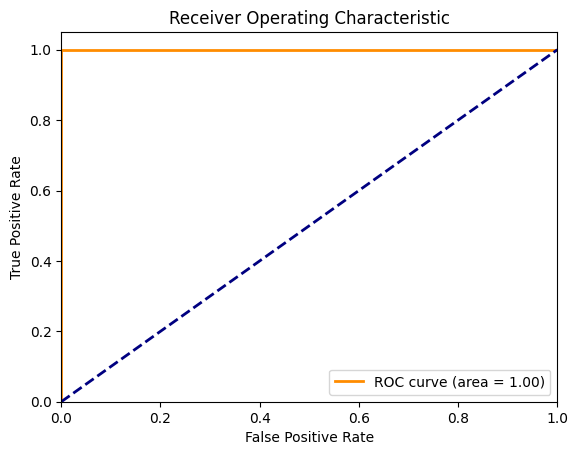

NameError: name 'f1_score' is not defined

In [17]:
import pandas as pd
import joblib
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Load model and data
model = joblib.load('fraud_detection_xgb_model.pkl')
df = pd.read_csv("enhanced_medical_fraud_data.csv")

# Prepare data (assuming same preprocessing as training)
X = df.drop('fraud', axis=1)
y = df['fraud']

# Split data (if not already split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Comprehensive evaluation
def evaluate_model(y_true, y_pred, y_proba):
    print("Class Distribution:")
    print(pd.Series(y_true).value_counts())
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Run evaluation
evaluate_model(y_test, y_pred, y_proba)

# Threshold analysis
def threshold_analysis(y_true, y_proba):
    thresholds = np.arange(0.1, 1.0, 0.1)
    results = []
    
    for thresh in thresholds:
        y_pred_thresh = (y_proba >= thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred_thresh).ravel()
        results.append({
            'Threshold': thresh,
            'TPR': tp/(tp+fn),
            'FPR': fp/(fp+tn),
            'Precision': tp/(tp+fp) if (tp+fp) > 0 else 0,
            'F1': f1_score(y_true, y_pred_thresh)
        })
    
    return pd.DataFrame(results)

# Display threshold metrics
threshold_df = threshold_analysis(y_test, y_proba)
print("\nThreshold Analysis:")
print(threshold_df)

# Class-specific testing
def test_class_samples(model, X, y, target_class, n_samples=5):
    class_indices = y[y == target_class].index
    sample_indices = np.random.choice(class_indices, n_samples, replace=False)
    
    samples = X.loc[sample_indices]
    actuals = y.loc[sample_indices]
    predictions = model.predict(samples)
    probabilities = model.predict_proba(samples)[:, 1]
    
    results = pd.DataFrame({
        'Actual': actuals,
        'Predicted': predictions,
        'Probability': probabilities
    })
    
    accuracy = (results['Actual'] == results['Predicted']).mean()
    
    print(f"\nTesting {n_samples} {['Non-Fraud', 'Fraud'][target_class]} Samples:")
    print(results)
    print(f"Accuracy: {accuracy:.2%}")
    return results

# Test both classes
non_fraud_results = test_class_samples(model, X_test, y_test, 0)
fraud_results = test_class_samples(model, X_test, y_test, 1)

In [18]:
import pandas as pd
import joblib

# Load trained model
model = joblib.load('fraud_detection_xgb_model.pkl')

# Define test cases with proper encoded values (adjust based on your encoders)
test_cases = [
    # Non-Fraud Case
    {
        'gender': 0,                    # Female
        'procedure_type': 2,             # X-Ray (non-fraud)
        'diagnosis_code': 1,             # I10 (Hypertension)
        'claim_month': 0,                # January
        'patient_age': 35,
        'provider_id': 5,
        'hospital_id': 8,
        'claim_amount': 4500.00,
        'num_procedures': 2,
        'days_admitted': 1,
        'previous_claims': 1,
        'billing_discrepancy': 0.08,
        'anomaly_score': 0.12,
        'month_fraud_risk': 0.25,
        'risk_score': 0.22
    },
    
    # Fraud Case
    {
        'gender': 1,                     # Male
        'procedure_type': 4,             # MRI Scan (fraud)
        'diagnosis_code': 3,             # C34 (Lung Cancer)
        'claim_month': 3,                # December
        'patient_age': 58,
        'provider_id': 27,
        'hospital_id': 99,               # Suspicious hospital
        'claim_amount': 18250.00,
        'num_procedures': 5,
        'days_admitted': 4,
        'previous_claims': 3,
        'billing_discrepancy': 0.82,
        'anomaly_score': 0.94,
        'month_fraud_risk': 0.35,
        'risk_score': 0.78
    }
]

# Convert to DataFrame (maintain feature order)
columns_order = [
    'patient_age', 'gender', 'provider_id', 'hospital_id', 'claim_month',
    'procedure_type', 'diagnosis_code', 'claim_amount', 'num_procedures',
    'days_admitted', 'previous_claims', 'billing_discrepancy', 'anomaly_score',
    'month_fraud_risk', 'risk_score'
]

test_df = pd.DataFrame(test_cases)[columns_order]

# Make predictions
predictions = model.predict(test_df)
probabilities = model.predict_proba(test_df)[:, 1]

# Display results
results = pd.DataFrame({
    'Case': ['Non-Fraud Example', 'Fraud Example'],
    'Predicted Class': predictions,
    'Fraud Probability': probabilities,
    'Prediction Label': np.where(predictions == 1, 'Fraud', 'Non-Fraud')
})

print("Prediction Results:")
print(results.to_string(index=False))

# Detailed output
print("\nDetailed Predictions:")
for idx, (pred, prob) in enumerate(zip(predictions, probabilities)):
    print(f"\nCase {idx+1}:")
    print(f"Features: {dict(test_df.iloc[idx])}")
    print(f"Prediction: {'Fraud' if pred == 1 else 'Non-Fraud'}")
    print(f"Confidence: {prob:.2%}")
    print(f"Risk Score: {test_df.iloc[idx]['risk_score']:.2f}")

Prediction Results:
             Case  Predicted Class  Fraud Probability Prediction Label
Non-Fraud Example                0           0.017312        Non-Fraud
    Fraud Example                1           0.999743            Fraud

Detailed Predictions:

Case 1:
Features: {'patient_age': 35.0, 'gender': 0.0, 'provider_id': 5.0, 'hospital_id': 8.0, 'claim_month': 0.0, 'procedure_type': 2.0, 'diagnosis_code': 1.0, 'claim_amount': 4500.0, 'num_procedures': 2.0, 'days_admitted': 1.0, 'previous_claims': 1.0, 'billing_discrepancy': 0.08, 'anomaly_score': 0.12, 'month_fraud_risk': 0.25, 'risk_score': 0.22}
Prediction: Non-Fraud
Confidence: 1.73%
Risk Score: 0.22

Case 2:
Features: {'patient_age': 58.0, 'gender': 1.0, 'provider_id': 27.0, 'hospital_id': 99.0, 'claim_month': 3.0, 'procedure_type': 4.0, 'diagnosis_code': 3.0, 'claim_amount': 18250.0, 'num_procedures': 5.0, 'days_admitted': 4.0, 'previous_claims': 3.0, 'billing_discrepancy': 0.82, 'anomaly_score': 0.94, 'month_fraud_risk': 0.35